In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import format_number

SEED = 42
np.random.seed(SEED)

2024-07-02 20:11:57.125598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def print_censored_rate(
    data: pd.DataFrame,
    name: str = 'Total'
):
    """
    Print the censored rate for the given data.
    Censored sequences are the ones where the churn date is not known (last `tte` < 0).

    Parameters
    ----------
    data : pd.DataFrame, optional
        Data to calculate the censored rate.
        If not provided, model data will be used.
    name : str, optional
        Name to print the censored rate.
    """
    cs = pd.Categorical(
        data.sort_values(['id', 'tp']).groupby('id')['tte'].last() < 0,
        categories=[False, True]
    ).value_counts().astype(float)

    print('{} Customers: {} | Censored: {} | Non-censored: {} | Censored Rate {}%'.format(
        name,
        format_number(cs.sum()),
        format_number(cs[True]),
        format_number(cs[False]),
        format_number(100 * cs[True] / cs.sum(), 2)
    ))

In [3]:
data = pd.read_csv('../files/churn-seq-predict.csv')

clear_output(wait=True)
print_censored_rate(data)
data

Total Customers: 2.854 | Censored: 2.854 | Non-censored: 0 | Censored Rate 100%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,months,failed_ratio,usage_diff,momentum
0,51b46d18c4de615d0f000019,1,2017-03-01,0.0,-1.0,2017-03-01,NaN,1,26.58,79.75,...,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00
1,51b46d18c4de615d0f000019,1,2017-04-01,1.0,-1.0,2017-03-01,NaN,1,26.58,79.75,...,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,-0.05
2,51b46d18c4de615d0f000019,1,2017-05-01,2.0,-1.0,2017-03-01,NaN,1,26.58,79.75,...,2.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,0.18
3,51b46d18c4de615d0f000019,1,2017-06-01,3.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.0,0.0,0.0,2.0,0.0,4.0,3.0,0.0,0.0,-0.19
4,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.0,0.0,0.0,2.0,0.0,5.0,4.0,0.0,0.0,-0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108343,667f05cb82ed8f32e1db1067,2850,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,105.19,105.19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00
108344,667f08bf8fe3bb5d0fe26aa7,2851,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,104.63,104.63,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00
108345,667f299482ed8f32e1db25a1,2852,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,90.00,90.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00
108346,667f5e508fe3bb5d0fe2ced6,2853,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,38.25,38.25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00


In [4]:
# Load Ensemble model
model = ChurnEnsemble(
    seed=SEED,
    verbose=1,
    path='../files/ensemble'
).set_data(
    data
).load()

model.get_params()

{'wtte': {'nn': 24,
  'hl': 2,
  'lr': 0.0001,
  'epochs': 200,
  'batch': 512,
  'lr_decay': 0,
  'stop': 0,
  'dropout': 0.1,
  'weight_l1': 0,
  'weight_l2': 1e-05,
  'init_alpha': None,
  'max_beta': 2.0,
  'shuffle': False,
  'epsilon': 1e-08},
 'xgb': {'n': 200,
  'lr': 0.01,
  'max_depth': 16,
  'stop': 0,
  'metric': 'auc',
  'min_child_weight': 1,
  'gamma': 0,
  'weight_l1': 0,
  'weight_l2': 1,
  'dropout': 0.2,
  'shuffle': False,
  'reg_unb': True}}

In [5]:
# Predict
model.predict()

model.results

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


,id,tfs,pred,tgt,segment,wa,wb,momentum,cid
0,1,0,0.094528,0,1,24.969492,1.690348,0.00,51b46d18c4de615d0f000019
1,1,1,0.109285,0,2,25.853718,1.701230,-0.05,51b46d18c4de615d0f000019
2,1,2,0.105179,0,1,27.182980,1.721709,0.18,51b46d18c4de615d0f000019
3,1,3,0.142374,1,4,27.783260,1.745798,-0.19,51b46d18c4de615d0f000019
4,1,4,0.127038,0,2,27.352007,1.768723,-0.65,51b46d18c4de615d0f000019
...,...,...,...,...,...,...,...,...,...
108343,2850,0,0.662194,1,5,6.323446,0.912393,0.00,667f05cb82ed8f32e1db1067
108344,2851,0,0.553969,1,5,8.768782,0.907432,0.00,667f08bf8fe3bb5d0fe26aa7
108345,2852,0,0.596155,1,5,7.367326,0.959249,0.00,667f299482ed8f32e1db25a1
108346,2853,0,0.737588,1,5,5.787423,0.965714,0.00,667f5e508fe3bb5d0fe2ced6


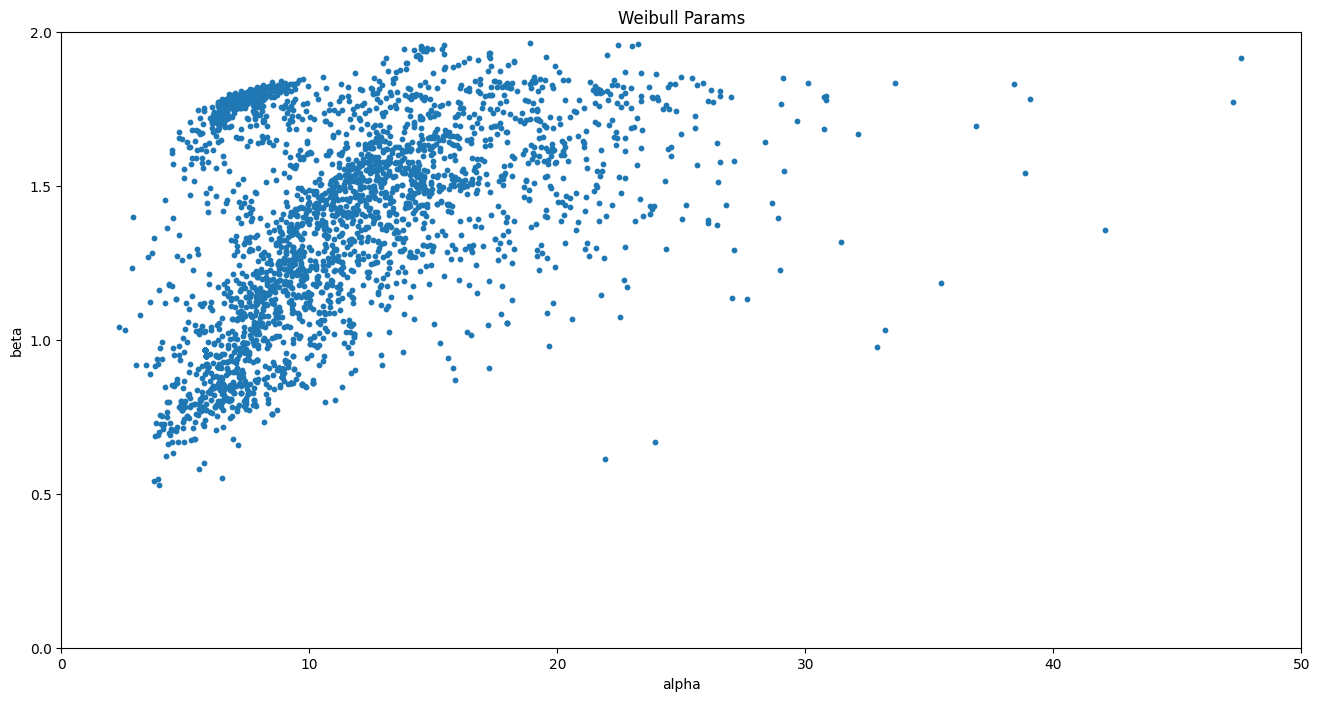

In [6]:
# Plot parameters distribution
model.wtte.plot_params_dist(model.wtte.results, loc=-1)

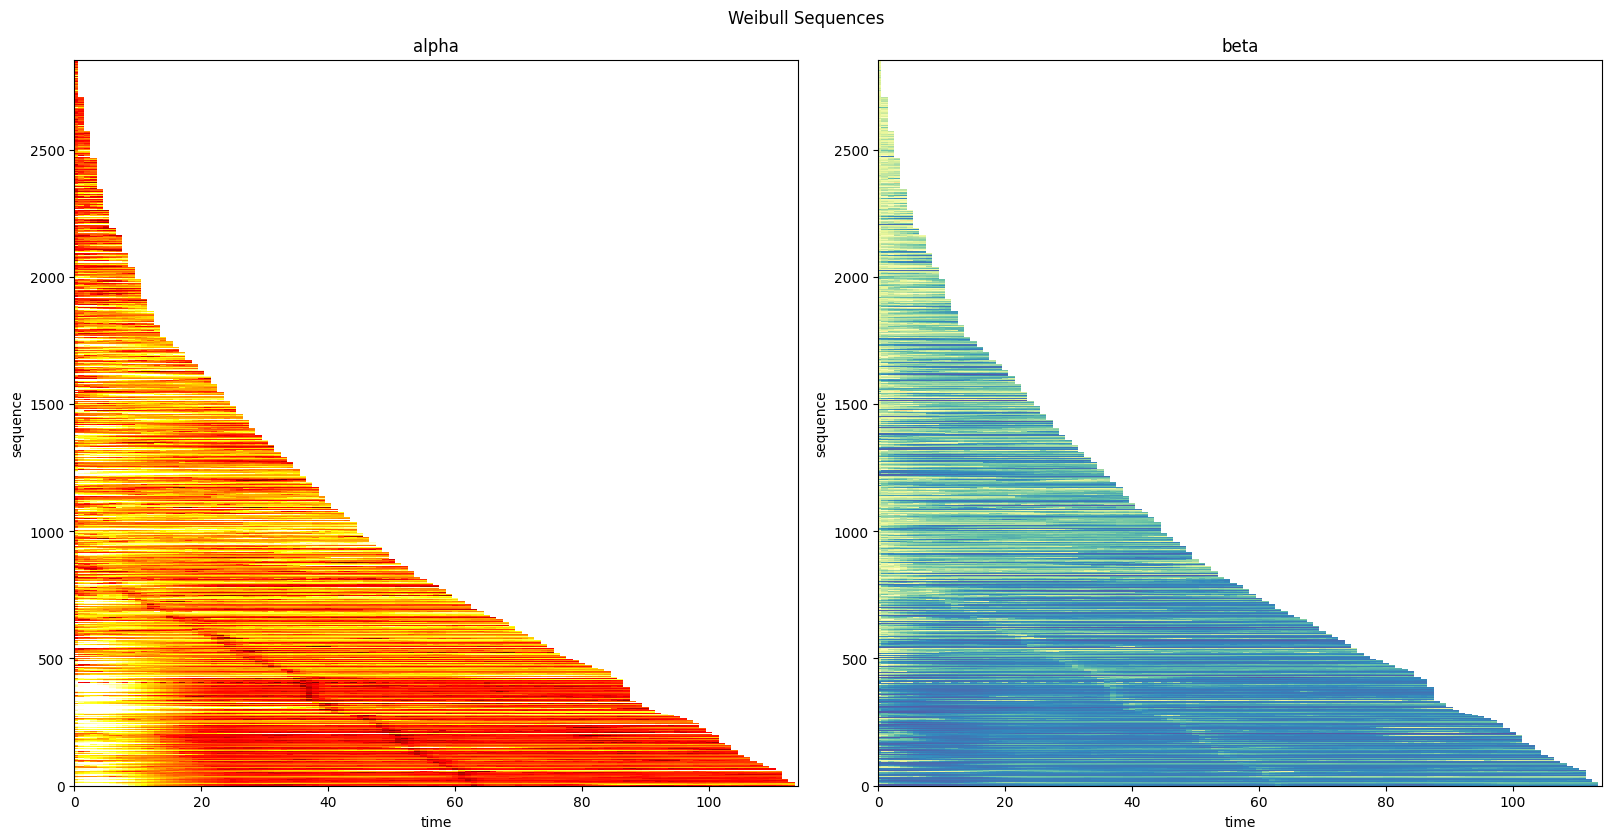

In [7]:
# Plot each customer Weibull alpha and beta parameters over time
model.wtte.plot_params_seq(model.wtte.results)

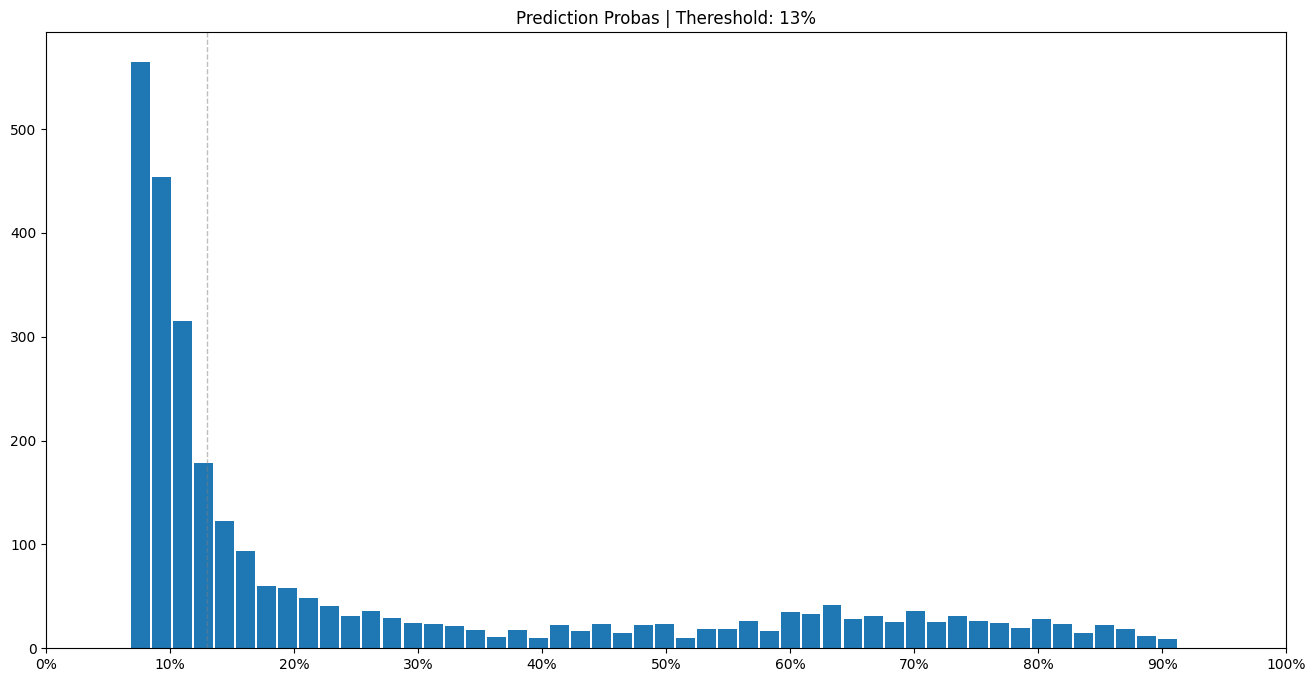

In [8]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram()

In [9]:
# Get the predictions DataFrame.
df = model.get_predictions(loc=-1)

df

,id,pred,tgt,segment,wa,wb,momentum,cid
87,1,0.405512,1,5,3.192951,1.081000,-22.60,51b46d18c4de615d0f000019
199,2,0.077087,0,3,7.636268,1.385705,2.52,51c6bee4885ef11f7200030b
287,3,0.078488,0,3,6.131057,1.715910,0.29,51d4af244e30af6436000001
398,4,0.074822,0,3,6.384195,1.699526,0.68,51de98a50f42e6597c00009c
510,5,0.070894,0,3,7.226551,1.770929,0.01,51e7ebf61aae11927e00001e
...,...,...,...,...,...,...,...,...
108343,2850,0.662194,1,5,6.323446,0.912393,0.00,667f05cb82ed8f32e1db1067
108344,2851,0.553969,1,5,8.768782,0.907432,0.00,667f08bf8fe3bb5d0fe26aa7
108345,2852,0.596155,1,5,7.367326,0.959249,0.00,667f299482ed8f32e1db25a1
108346,2853,0.737588,1,5,5.787423,0.965714,0.00,667f5e508fe3bb5d0fe2ced6
